<a href="https://colab.research.google.com/github/Katrin-Leberfinger/Hybrid-gender-debiased-music-recommendation/blob/main/models_using_lfm2b_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT for text embedding

Code Source:
https://gist.github.com/shubhamagarwal92/37ccb747f7130a35a8e76aa66d60e014

Interesting articles
https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#31-running-bert-on-our-text
https://www.kaggle.com/hassanamin/bert-pytorch-cola-classification


In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 14.5 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 6.5 MB 61.8 MB/s 
     |████████████████████████████████| 596 kB 86.1 MB/s 
     |████████████████████████████████| 895 kB 67.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from transformers import BertConfig, BertPreTrainedModel, BertModel, BertForSequenceClassification
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
from torch import nn
from transformers import BertModel
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Read Data

In [3]:
# data: track_artist -	track_name -	track_tag - track_id

def read_items_data_bert(data, id_col, text_col, max_length=512):
  tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny') 
  #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
  items = torch.Tensor([])
  attentions = torch.Tensor([])
  item2pos = dict()
  pos2item = dict()
  token2id = dict()
  num_items = 0
  num_tokens = 0
  max_item_len = 0

  for index, row in data.iterrows():
    # for each item:
    item_id = row[id_col]
    item_words = []
    item2pos[item_id] = num_items
    pos2item[num_items] = item_id


    inputs = tokenizer.encode_plus(
        row[text_col], 
        None,
        add_special_tokens=True,
        max_length = max_length,
        pad_to_max_length=True
        
    )

    tokens = inputs["input_ids"]
    attention = inputs['attention_mask']
    tokens=torch.tensor(tokens, dtype=torch.long).unsqueeze(0)
    attention=torch.tensor(attention, dtype=torch.long).unsqueeze(0)

    items = torch.concat((items, tokens))
    attentions = torch.concat((attentions, attention))
    num_items = num_items + 1

  return items, attentions, item2pos, pos2item, token2id, max_item_len

In [4]:
# data: user_id - item_id - rating

def read_ratings_data(data, item2pos, id_col, rating_col, user_col):
    ratings = torch.Tensor(len(data), 3)
    user2id = dict()
    id2user = dict()
    num_users = 0
    i = 0
    for _, row in data.iterrows():
        raw_user = row[user_col] 

        try:
          user2id[raw_user]
        except:
          user2id[raw_user] = num_users
          id2user[num_users] = raw_user
          num_users = num_users + 1

        user = user2id[raw_user]
        item = int(item2pos[row[id_col]]) #track_id
        rating = int(row[rating_col]) # count

        ratings[i][0] = user
        ratings[i][1] = item
        ratings[i][2] = rating / data[rating_col].max()
        i = i+1


    return ratings, user2id, id2user


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Master\ Thesis/data

/content/drive/MyDrive/Master Thesis/data


## Read Data: Lyrics 

In [46]:
data_tracks_lyrics = pd.read_csv("music/data_tracks_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_tracks_tags_lyrics = pd.read_csv("music/data_tracks_tags_lyrics.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_bio = pd.read_csv("music/data_artists_biography.txt", sep=",").drop(['Unnamed: 0'],axis=1).dropna()
data_interaction = pd.read_csv("music/data_user_track_interaction.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

data_tracks_tags_lyrics = data_tracks_tags_lyrics.merge(data_bio)
data_interaction = data_interaction.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates())

data_user = pd.read_csv("music/data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)

In [47]:
# filter out playcount 1
data_interaction = data_interaction[data_interaction['count'] != 1]

In [48]:
import random
selected_user = random.sample(list(data_interaction.user_id.unique()), 800)
selected_items = random.sample(list(data_interaction.track_id.unique()), 1000)
data_interaction = data_interaction.loc[(data_interaction.user_id.isin(selected_user)) & (data_interaction.track_id.isin(selected_items))]

In [49]:
data_interaction.loc[data_interaction['count']<2., 'count'] = 0.
data_interaction.loc[data_interaction['count']>=2., 'count'] = 1.

In [50]:
rating_col = 'count'
item_col = 'track_id'
user_col = 'user_id'
text_col = 'tags'
data_items_eval = data_tracks_tags_lyrics

## CV and balance data set

In [51]:
data_interaction['fold'] = np.random.randint(1, 6, data_interaction.shape[0])

import random
idx = []
for _,df in data_interaction.groupby('fold'):
  len_pos = len(df[df[rating_col]==1])
  len_neg = len(df[df[rating_col]==0])
  if len_pos < len_neg:
    df = df[df[rating_col]==0].sample(len_pos).append(df[df[rating_col]==1])
  elif len_pos > len_neg:
    df = df[df[rating_col]==1].sample(len_pos).append(df[df[rating_col]==0])
  idx.extend(df.index.values.tolist())

In [52]:
# remove user with too little playcount
# add negative samples
data_interaction_new = pd.DataFrame(columns = data_interaction.columns)
for user_id,df in data_interaction.groupby('user_id'):
  if len(df) >= 10:
    df_tmp = df.merge(data_items_eval[['track_id']], how = 'right')
    neg_list = random.sample(list(df_tmp[np.isnan(df_tmp.user_id)].track_id.values), len(df))
    df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
    data_interaction_new=data_interaction_new.append(df)
    data_interaction_new=data_interaction_new.append(df_neg)
data_interaction_new = shuffle(data_interaction_new)

In [53]:
data_interaction_new['fold'] = np.random.randint(1, 6, data_interaction_new.shape[0])

test_fold = 1
val_fold = 2


data_interaction_train = data_interaction_new.loc[((data_interaction_new.fold != test_fold) & (data_interaction_new.fold != val_fold)), [user_col, item_col, rating_col]]
data_interaction_test = data_interaction_new.loc[data_interaction_new.fold == test_fold, [user_col, item_col, rating_col]]
data_interaction_val = data_interaction_new.loc[data_interaction_new.fold == val_fold, [user_col, item_col, rating_col]]

In [54]:
# itermin solution (maybe change later)
for user_id,df in data_interaction_test.groupby('user_id'):

  df_tmp = df.merge(data_items_eval[['track_id']], how = 'right')
  neg_list = list(df_tmp.loc[df_tmp.isna().any(axis=1),].track_id.values)
  df_neg = pd.DataFrame({'user_id': user_id, 'track_id':neg_list, 'count':0})
  data_interaction_test=data_interaction_test.append(df_neg)
data_interaction_test = shuffle(data_interaction_test)
data_interaction_test

,user_id,track_id,count
1705,35161,3466459.0,0
3182,18190,3210124.0,0
1733,13676,194963.0,0
1951,32196,3471121.0,0
1118,561,6094416.0,0
...,...,...,...
3935,6415,6112759.0,0
1156,13676,6205458.0,0
4399,18190,3690163.0,0
1154,260,4981016.0,0


# Ask Me Anything Rating

Code source: https://github.com/nlp-deepcbrs/amar

## **BERT Model**

In [55]:
items, attentions, item2pos, pos2item, token2id, max_item_len = read_items_data_bert(data_items_eval, item_col, text_col, 128)


ratings_train, user2id_train, id2user_train = read_ratings_data(data_interaction_train, item2pos,  item_col, rating_col, user_col)
ratings_test, user2id_test, id2user_test = read_ratings_data(data_interaction_test, item2pos,  item_col, rating_col, user_col)
ratings_val, user2id_val, id2user_val = read_ratings_data(data_interaction_val, item2pos,  item_col, rating_col, user_col)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [56]:
class AMARBase(nn.Module):
  """Model with LT tables for user and items."""
  def __init__(self, hidden_dense_layer_size, item_embeddings_size, num_users, num_items):
      super(AMARBase, self).__init__()

      self.model1_layer1 = nn.Embedding(num_items, item_embeddings_size)

      self.model2_layer1 = nn.Embedding(num_users, user_embeddings_size)
      
      self.linear = nn.Linear(hidden_dense_layer_size, 1)
      self.sigmoid = nn.Sigmoid()
      
  def forward(self, x):
      y1 = self.model1_layer1(x[0])
      
      y2 = self.model2_layer1(x[2])

      y = torch.cat([y1, y2], 1)
      y = self.linear(y)
      return self.sigmoid(y)


In [57]:
class AMARBert(nn.Module):
    def __init__(self, hidden_dense_layer_size, item_embeddings_size, num_users, num_items):
        super(AMARBert, self).__init__()
        
        self.model1_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.model1_layer3 = nn.Dropout(p=0.2)

        self.model2_layer1 = nn.Embedding(num_users, user_embeddings_size)

        self.model3_layer1 = nn.Embedding(num_items, item_embeddings_size)

        self.embedding =  nn.Dropout(p=0.2)
        
        self.linear = nn.Linear(hidden_dense_layer_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #_, y1 = self.model1_layer2(x[1], attention_mask = x[3],  return_dict=False)
        output, y1 = self.model1_layer2(x[1],  return_dict=False)
        y1 = output[:, 0, :]
        # pooled_output (=y1) is the output of the CLS token
        # "Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification."
        # https://stackoverflow.com/questions/63673511/how-to-use-the-outputs-of-bert-model?rq=1
        # https://towardsdatascience.com/bert-to-the-rescue-17671379687f
       # y1 = self.model1_layer3(y1)
        
        y2 = self.model2_layer1(x[2])

        y3 = self.model3_layer1(x[0])

        y = torch.cat([y1, y2, y3], 1)
        y = self.embedding(y)
        y = self.linear(y)
        return self.sigmoid(y)


In [ ]:
class AMARBert2(nn.Module):
    def __init__(self, hidden_dense_layer_size, item_embeddings_size, num_users, num_items):
        super(AMARBert, self).__init__()
        
        self.model1_layer1 = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.model1_layer2 = nn.Dropout(p=0.2)


        self.model2_layer1 = nn.Embedding(num_users, user_embeddings_size)

        self.model3_layer1 = nn.Embedding(num_items, item_embeddings_size)

        self.model4_layer2 = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.model4_layer3 = nn.Dropout(p=0.2)

        self.embedding =  nn.Dropout(p=0.2)
        
        self.linear = nn.Linear(hidden_dense_layer_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #_, y1 = self.model1_layer2(x[1], attention_mask = x[3],  return_dict=False)
        output, y1 = self.model1_layer1(x[1],  return_dict=False)
        y1 = output[:, 0, :]
       # y1 = self.model1_layer2(y1)
        
        y2 = self.model2_layer1(x[2])

        y3 = self.model3_layer1(x[0])

        output, y4 = self.model4_layer1(x[1],  return_dict=False)

        y = torch.cat([y1, y2, y3, y4], 1)
        y = self.embedding(y)
        y = self.linear(y)
        return self.sigmoid(y)


In [58]:
# Params: items_data, ratings_data, genres_data
device = 'cuda'

import numpy as np
num_examples=ratings_train.size(0)
item_text_embeddings_size = 128
user_embeddings_size = 50
item_embeddings_size = 50


num_users = len(data_interaction[user_col].drop_duplicates())
num_items = max(max(ratings_train[:, 1]), max(ratings_test[:, 1])).int().item()+1

hidden_dense_layer_size_base = item_embeddings_size + user_embeddings_size
model_base = AMARBase( hidden_dense_layer_size_base, item_embeddings_size, num_users, num_items)

hidden_dense_layer_size_bert = item_embeddings_size + item_text_embeddings_size + user_embeddings_size
model_bert = AMARBert( hidden_dense_layer_size_bert, item_embeddings_size, num_users, num_items)

model = model_bert

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
from transformers import get_linear_schedule_with_warmup
criterion = nn.BCEWithLogitsLoss() 
# # https://huggingface.co/transformers/v1.0.0/migration.html
lr = 1e-3
num_total_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)  

scheduler = get_linear_schedule_with_warmup(
   optimizer,
   num_warmup_steps=num_warmup_steps,
   num_training_steps=num_total_steps
)


num_epochs=30
batch_size=256 

loss_train = []
loss_val = []

for e in range(num_epochs):
    # shuffle and split training examples in batches
    indices = torch.randperm(ratings_train.shape[0]).split(batch_size)

    #remove last element so that all the batches have equal size
    indices = indices[:len(indices)-1] 

    average_cost = 0

    model.train()

    for t, v in enumerate(indices):
        #items positions
        curr_items_ids_batch = ratings_train[v, 1]

        # items descriptions
        curr_items_batch = items[curr_items_ids_batch.numpy(),:].to(device)
        curr_attentions_batch = attentions[curr_items_ids_batch.numpy(),:].to(device)
        
        # users ids
        curr_users_batch = ratings_train[v, 0].to(device)

        # model inputs
        inputs = [curr_items_ids_batch.to(device).type(torch.LongTensor), curr_items_batch.type(torch.LongTensor), curr_users_batch.type(torch.LongTensor), curr_attentions_batch.type(torch.LongTensor)]

        # model targets
        targets = ratings_train[v, 2]

        # callback that does a single batch optimization step
        optimizer.zero_grad()

        # backward propagation
        outputs = model(inputs)
        
        
        outputs = outputs.reshape(-1,)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # evaluate current loss function value
        average_cost = average_cost + loss
        
    # compute loss on validation set

    with torch.no_grad():
      indices_val = torch.randperm(ratings_val.shape[0]).split(batch_size)

      average_cost_val = 0

      for t, v in enumerate(indices_val):
              v = v.type(torch.LongTensor)
              #items positions
              curr_items_ids_batch = ratings_val[v, 1]

              # items descriptions
              curr_items_batch = items[curr_items_ids_batch.numpy(),:].to(device)
              curr_attentions_batch = attentions[curr_items_ids_batch.numpy(),:].to(device)
              
              # users ids
              curr_users_batch = ratings_val[v, 0].to(device)

              # model inputs
              inputs = [curr_items_ids_batch.to(device).type(torch.LongTensor), curr_items_batch.type(torch.LongTensor), curr_users_batch.type(torch.LongTensor), curr_attentions_batch.type(torch.LongTensor)]

              # model targets
              targets = ratings_val[v, 2]

              # backward propagation
              outputs = model(inputs)

              outputs = outputs.reshape(-1,)
              loss = criterion(outputs, targets)
              average_cost_val = average_cost + loss

      average_cost_val = average_cost_val / len(indices_val)
      loss_val.append(average_cost_val.item())


    # evaluate average cost per epoch
    average_cost = average_cost / len(indices)
    loss_train.append(average_cost.item())
    print(f"Average cost per epoch: Train: {average_cost.item()}, Val: {average_cost_val.item()}")


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Average cost per epoch: Train: 0.7242475748062134, Val: 1.4565099477767944
Average cost per epoch: Train: 0.7273387908935547, Val: 1.4582102298736572
Average cost per epoch: Train: 0.7191010117530823, Val: 1.4498050212860107
Average cost per epoch: Train: 0.7117233872413635, Val: 1.4275760650634766
Average cost per epoch: Train: 0.6993715763092041, Val: 1.4015315771102905
Average cost per epoch: Train: 0.689010739326477, Val: 1.3840696811676025
Average cost per epoch: Train: 0.681664228439331, Val: 1.3765108585357666
Average cost per epoch: Train: 0.66888827085495, Val: 1.3682613372802734
Average cost per epoch: Train: 0.6646625995635986, Val: 1.3659460544586182
Average cost per epoch: Train: 0.6545223593711853, Val: 1.3614150285720825
Average cost per epoch: Train: 0.6551294326782227, Val: 1.358638048171997
Average cost per epoch: Train: 0.6618102192878723, Val: 1.373974084854126
Average cost per epoch: Train: 0.6372389793395996, Val: 1.3483710289001465
Average cost per epoch: Train: 

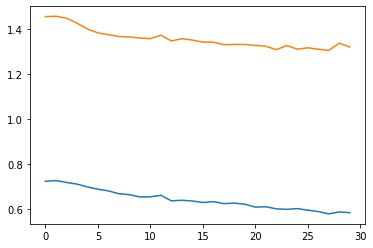

In [60]:
plt.plot(loss_train)
plt.plot(loss_val)

## **BERT**: Get predictions

In [ ]:
def get_feature_vector(model, inputs, batch_size):

  layer = model._modules.get('model1_layer3')

  embedding = torch.zeros((batch_size, 128))
  def copy_data(m, i, o):
          embedding.copy_(o.data)
  h = layer.register_forward_hook(copy_data)
  model(inputs)
  h.remove()
  return embedding

In [82]:
predictions = {}

with torch.no_grad():
  indices_test = torch.randperm(ratings_test.shape[0]).split(batch_size)

  average_cost = 0

  for t, v in enumerate(indices_test):
          v = v.type(torch.LongTensor)
          #items positions
          curr_items_ids_batch = ratings_test[v, 1]

          # items descriptions
          curr_items_batch = items[curr_items_ids_batch.numpy(),:].to(device)
          curr_attentions_batch = attentions[curr_items_ids_batch.numpy(),:].to(device)
          
          # users ids
          curr_users_batch = ratings_test[v, 0].to(device)

          # model inputs
          inputs = [curr_items_ids_batch.to(device).type(torch.LongTensor), curr_items_batch.type(torch.LongTensor), curr_users_batch.type(torch.LongTensor), curr_attentions_batch.type(torch.LongTensor)]

          # model targets
          targets = ratings_test[v, 2]

          # backward propagation
          outputs = model(inputs)

          outputs = outputs.reshape(-1,)
          loss = criterion(outputs, targets)
          average_cost = average_cost + loss

          # save prediction for each user
          
          for i in range(outputs.shape[0]):

            real_user_id = id2user_test[curr_users_batch[i].item()]
            try:
              predictions[real_user_id] 
            except:
              predictions[real_user_id] = []

            predictions[real_user_id].append([pos2item[curr_items_ids_batch[i].item()], 
                                              outputs[i].item()])
            
  print(f"Average cost test: {average_cost / len(indices_test)}")

Average cost test: 0.9357069134712219


In [ ]:
# batch_size = 256

# indices = ratings_test[:,0].unique()
# predictions = {}
# feature_vectors = {}

# model.eval()

# for curr_users_batch in indices:

#   curr_users_batch = curr_users_batch.to(device).reshape(-1)
#  # curr_users_batch = curr_users_batch.repeat(batch_size)
#   indices_items = ratings_test[:,1].unique()#.split(batch_size)[:-1]
#   for curr_items_ids_batch in indices_items:
    
#     curr_items_ids_batch = int(curr_items_ids_batch.item())

#     curr_items_batch = items[curr_items_ids_batch,:].to(device).reshape(1, -1)
    
    
#     curr_attentions_batch = attentions[curr_items_ids_batch,:].to(device).reshape(1, -1)

#     inputs = [ curr_items_batch.type(torch.LongTensor), curr_users_batch.type(torch.LongTensor), curr_attentions_batch.type(torch.LongTensor)]
    
#     targets = model(inputs)
#     item_list = []
    
    
#     # save prediction for each user
#     real_user_id = id2user_test[curr_users_batch[0].item()]

#     for i in range(targets.shape[0]):
    
#       try:
#         predictions[real_user_id] 
#       except:
#         predictions[real_user_id] = []

#       predictions[real_user_id].append([pos2item[curr_items_ids_batch], 
#                                         targets[i].item()])
    
#     # save embedding layer for each item
#     feature_vector = get_feature_vector(model, inputs, batch_size)
#     try:
#       feature_vectors[pos2item[curr_items_ids_batch]]
#     except:
#       feature_vectors[pos2item[curr_items_ids_batch]] = []
#     feature_vectors[pos2item[curr_items_ids_batch]].append(feature_vector)
        




In [83]:
topn=10
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user in predictions:
    item_list = []
    user_prediction = predictions[user]

    user_prediction = sorted(user_prediction,key=lambda x: (x[1]), reverse=True)
    n = 1
    for item, rating in user_prediction:
        if item  not in item_list:
          item_list.append(item)
          results_df = pd.concat((results_df, pd.DataFrame(data={user_col:[user],item_col:[item],rating_col:[rating]})))
          results.append([user, item, rating])
          if n >= topn:
              break
          n = n + 1


# Most popular recommendation


In [ ]:
topn = 10

item_popularity_df = data_interaction.groupby(item_col)[rating_col].sum().sort_values(ascending=False).reset_index()

predictions = {}

for real_user_id in data_interaction_test.userId:
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train[user_col] == real_user_id]['movieId'].values
    item_popularity_df_user = item_popularity_df[~item_popularity_df[item_col].isin(items_to_ignore)]
    predictions[real_user_id].append(item_popularity_df_user.head(topn)[item_col].values.tolist())

In [ ]:
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={user_col:[user],item_col:[item],rating_col:[rating]})))
        results.append([user, item, rating])

# Random recommendation

In [171]:
topn = 10

predictions = {}

for real_user_id in data_interaction_test.user_id:
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train[user_col] == real_user_id][item_col].values
    item_df_user = data_interaction[~data_interaction[item_col].isin(items_to_ignore)]
    predictions[real_user_id].append(random.sample(set(item_df_user['track_id'].values), topn))

In [ ]:
predictions

In [173]:
results = []
results_df = pd.DataFrame(columns = [user_col, item_col, rating_col])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={user_col:[user],item_col:[item],rating_col:[rating]})))
        results.append([user, item, rating])

# Evaluate predictions

Scores: F1@10, ndcg, MAP@k

In [ ]:
def ndcg_at(predictions, labels, k=10, assume_unique=True):
    """Compute the normalized discounted cumulative gain at K.
    Compute the average NDCG value of all the queries, truncated at ranking
    position k. The discounted cumulative gain at position k is computed as:
        sum,,i=1,,^k^ (2^{relevance of ''i''th item}^ - 1) / log(i + 1)
    and the NDCG is obtained by dividing the DCG value on the ground truth set.
    In the current implementation, the relevance value is binary.
    If a query has an empty ground truth set, zero will be used as
    NDCG together with a warning.
    Source: https://gist.github.com/tgsmith61591/d8aa96ac7c74c24b33e4b0cb967ca519
    Parameters
    ----------
    predictions : array-like, shape=(n_predictions,)
        The prediction array. The items that were predicted, in descending
        order of relevance.
    labels : array-like, shape=(n_ratings,)
        The labels (positively-rated items).
    k : int, optional (default=10)
        The rank at which to measure the NDCG.
    assume_unique : bool, optional (default=True)
        Whether to assume the items in the labels and predictions are each
        unique. That is, the same item is not predicted multiple times or
        rated multiple times.
    Examples
    --------
    >>> # predictions for 3 users
    >>> preds = [[1, 6, 2, 7, 8, 3, 9, 10, 4, 5],
    ...          [4, 1, 5, 6, 2, 7, 3, 8, 9, 10],
    ...          [1, 2, 3, 4, 5]]
    >>> # labels for the 3 users
    >>> labels = [[1, 2, 3, 4, 5], [1, 2, 3], []]
    >>> ndcg_at(preds, labels, 3)
    0.3333333432674408
    >>> ndcg_at(preds, labels, 10)
    0.48791273434956867
    References
    ----------
    .. [1] K. Jarvelin and J. Kekalainen, "IR evaluation methods for
           retrieving highly relevant documents."
    """

    def _inner_ndcg(pred, lab):
        # if we do NOT assume uniqueness, the set is a bit different here
        if not assume_unique:
            lab = np.unique(lab)

        n_lab = lab.shape[0]
        n_pred = pred.shape[0]
        n = min(max(n_pred, n_lab), k)  # min(min(p, l), k)?

        # similar to mean_avg_prcsn, we need an arange, but this time +2
        # since python is zero-indexed, and the denom typically needs +1.
        # Also need the log base2...
        arange = np.arange(n, dtype=np.float32)  # length n

        # since we are only interested in the arange up to n_pred, truncate
        # if necessary
        arange = arange[:n_pred]
        denom = np.log2(arange + 2.)  # length n
        gains = 1. / denom  # length n

        # compute the gains where the prediction is present in the labels
        dcg_mask = np.in1d(pred[:n], lab, assume_unique=assume_unique)
        dcg = gains[dcg_mask].sum()

        # the max DCG is sum of gains where the index < the label set size
        max_dcg = gains[arange < n_lab].sum()
        return dcg / max_dcg


    return _inner_ndcg(predictions, labels)

In [84]:
scores = []
for user, df in results_df.groupby(user_col):
  df = df.drop_duplicates(subset=item_col)
  y_true_sorted = data_interaction_test.loc[data_interaction_test[user_col] == user].sort_values(rating_col, ascending=False)
  y_true_df = pd.merge(data_items_eval[[item_col]], y_true_sorted[[item_col, rating_col]], 'left').fillna(0)
  y_true_ndcg = y_true_df[rating_col].values
  y_true_df.loc[y_true_df[rating_col] > 0, rating_col] = 1
  y_true = y_true_df[rating_col].values

  y_pred_df = pd.merge(data_items_eval[[item_col]], df[[item_col, rating_col]], 'left').fillna(0)
  y_pred_ndcg = y_pred_df[rating_col].values
  y_pred_df.loc[y_pred_df[rating_col] > 0, rating_col] = 1
  y_pred = y_pred_df[rating_col].values

  if y_true.sum() >= 1:
    score = f1_score(y_true, y_pred)
    scores.append(score)

print("F1 Score: ", np.mean(scores))

ValueError: ignored

# Interpretability of Bias

- Find correlations between user gender and item gender (Pearsons correlation)
- For each track get proportion of female/male user => compare train and recommendataion data
- Check if genderness increased/decreased in recommendations (in comparision to training data) 
- Compare distribution of genderness between history and recommendations 
  - "Delta Metric of Genderness" (https://arxiv.org/pdf/2108.06973.pdf)
  - Proportion tests: Fisher exact test, Chi-Square



In [ ]:
data_artists = pd.read_csv("data_artists.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_artists.columns = ['track_artist', 'type', 'gender_artist']
data_user_track_interaction = pd.read_csv("data_user_track_interaction.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user = pd.read_csv("data_user.txt", sep="\t").drop(['Unnamed: 0'],axis=1)
data_user.columns = ['user_id', 'gender_user']

a = []
for i in  data_artists.track_artist.values:
  a.append(i.lower())
data_artists['track_artist'] = a

In [ ]:
df_tmp = pd.merge(data_user_track_interaction, data_user, 'inner')
df_all = pd.merge(df_tmp, data_artists, on = 'track_artist').drop_duplicates()
df_all = df_all.loc[(df_all['gender_artist'] != 'Unknown') & (df_all['gender_artist'] != 'other')]

replace_dict1 = {'m' : 0, 'f' : 1}
replace_dict2 = {'male' : 0, 'female' : 1}
df_all['gender_user'] = df_all['gender_user'].replace(replace_dict1)
df_all['gender_artist'] = df_all['gender_artist'].replace(replace_dict2)

## Correlation between user and item gender

In [ ]:
# Proportion of female items in all female user
prop_female = 0
# Proportion of female items in all male user
prop_male = 0
for group, df in df_all.groupby('gender_user'):
  if group == 0:
    prop_male = df.gender_artist.sum() / len(df)
  else:
    prop_female = df.gender_artist.sum() / len(df)

print(f'In the history data, all female users listen to {round(prop_female*100, 2)} % female itmes.')
print(f'In the history data, all male users listen to {round(prop_male*100, 2)} % female itmes.')

# Pearson correlation
print('The attributes gender_user and gender_artist show a correlation of ', df_all.gender_user.corr(df_all.gender_artist))

In the history data, all female users listen to 8.3 % female itmes.
In the history data, all male users listen to 2.67 % female itmes.
The attributes gender_user and gender_artist show a correlation of  0.10665398232086548


In [ ]:
from scipy.stats import fisher_exact
tab = pd.crosstab(df_all.gender_user, df_all.gender_artist)
stats, p_value = fisher_exact(tab)
print(p_value)
# if p-value <= 0.05 => gender_user and gender_artist are independent

2.1905224050321245e-05


## Delta metric of genderness

 For user u_i: (prop_female(rec) - prop_female(history)) / prop_female(history)

 If positive: more female tracks are recommended to the user

In [ ]:
df_tmp = pd.merge(results_df, data_user, 'inner')
df_artists_tmp = pd.merge(df_tmp, data_user_track_interaction[['track_artist', 'track_id']])
df_rec = pd.merge(df_artists_tmp, data_artists, on = 'track_artist').drop_duplicates()
df_rec = df_rec.loc[(df_rec['gender_artist'] != 'Unknown') & (df_rec['gender_artist'] != 'other')]
df_rec['gender_user'] = df_rec['gender_user'].replace(replace_dict1)
df_rec['gender_artist'] = df_rec['gender_artist'].replace(replace_dict2)

In [ ]:
prop_female_rec = df_rec.gender_artist.sum()
prop_female_history = df_all.gender_artist.sum()
delta = (prop_female_rec - prop_female_history) / prop_female_history

if delta > 0:
  print(f'The value of delta is {delta} and therefore more female tracks are recommended to user.')
else:
  print(f'The value of delta is {delta} and therefore more male tracks are recommended to user.')

The value of delta is -1.0 and therefore more male tracks are recommended to user.


## Proportion test

In [ ]:
# Fisher exact test

from scipy.stats import fisher_exact
tab = pd.crosstab(df_rec.gender_artist, df_all.gender_artist)
stats, p_value = fisher_exact(tab)
if p_value <= 0.05:
  print(f'The attributes gender_artist of the history and recommendation data are significantly independent.')

# if p-value <= 0.05 => gender_x and gender_y are independent

In [ ]:
# z-test

from statsmodels.stats.proportion import proportions_ztest
significance = 0.005
sample_size_hist = df_all.gender_artist.count()
sample_success_hist = df_all.gender_artist.sum()
sample_success_rec = df_rec.gender_artist.count()
sample_size_rec = df_rec.gender_artist.sum()
successes = np.array([sample_success_hist, sample_success_rec])
samples = np.array([sample_size_hist, sample_size_rec])
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
if p_value <= 0.05:
  print(f'The proportions of gender_artist of the history and recommendation data are significantly different.')
# if p-value <= 0.05 => the proportions are significantly different

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/proportion.py:824: RuntimeWarning: divide by zero encountered in true_divide
  prop = count * 1. / nobs
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/proportion.py:840: RuntimeWarning: divide by zero encountered in true_divide
  nobs_fact = np.sum(1. / nobs)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


# Predict artist gender

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
data_all_info = pd.read_csv("music/data_all_info.txt", sep="\t").drop(['Unnamed: 0'],axis=1).dropna()
data_all_info = data_all_info.loc[data_all_info.artist_gender != 'other' ]

In [ ]:
input = feature_vectors

In [ ]:
df_features = pd.DataFrame()
id_col = []

for id in data_interaction_test[item_col].unique():
  id_col.append(id)
  df_features = df_features.append(pd.DataFrame(input[id][0].detach().numpy()))

df_features[item_col] = id_col

In [ ]:
df_features = pd.merge(df_features, data_all_info)

In [ ]:
df_features.loc[df_features.artist_gender == 'female', 'artist_gender'] = 0
df_features.loc[df_features.artist_gender == 'male', 'artist_gender'] = 1
df_features.artist_gender = df_features.artist_gender.astype('int')

In [ ]:
X = df_features.iloc[:,:128]
y = df_features.artist_gender
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [ ]:
#clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test.values, y_pred))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test.values, y_pred))
print("Recall: ", metrics.recall_score(y_test.values, y_pred))
print("Precision: ", metrics.precision_score(y_test.values, y_pred))

Accuracy: 0.7887323943661971
Balanced Accuracy: 0.7465686274509804
Recall:  0.8431372549019608
Precision:  0.86


In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp.head(10)

104    0.226804
98     0.140306
17     0.131687
81     0.114796
127    0.111745
62     0.091315
5      0.083488
111    0.051955
3      0.047903
69     0.000000
dtype: float64

---------------------------

# Next steps

[x] Train test split 

[x] Implement CV

[x] Balance data set (use as many listened as unlistened tracks - randomly chosing them)

[x] Use Popularity model as baseline

[x] Check index behaviour!!! (pos2item,...)

[x] Test/train split (https://colab.research.google.com/github/d2l-ai/d2l-en-colab/blob/master/chapter_recommender-systems/movielens.ipynb)

[x] Verify BERT Tokenizer

[x] Verify data reading with new movie data

[x] Try out gender interpretability

[x] Add tags data (instead of lyrics)

[x] Get more data

[x] Clean lyrics data (remove non-english ones and repeated parts)

[x] Use embedding of model to predict gender of artist

[x] Try to find song writer gender (not priority) => tried this out but could not find a general solution

[ ] Implement ndcg (https://github.com/Jenniferz28/Collaborative-Filtering-Recommendation/blob/69a2400736a628de34620318abe861cc9a19e621/ndcg.py#L77)

[x] Clean up code and move to repository

[x] Implement evaluation with using all items in dataset

[ ] BERT make sure this is correct!

[ ] Try out correlation interpretability things (e.g. "Exploring Artist Gender Bias in Music Recommendation"

[ ] Remove 'important' feature vector from recommendataion model and compare recommendation performance + prediction perforamcne

